In [1]:
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Activation, Convolution1D, Dense, Dropout, Flatten, MaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier

import math
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from python_speech_features import fbank, logfbank
from scipy.signal import spectrogram

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import soundfile

from onset_detection.metrics import onset_metric
from onset_detection.read_data import read_data

Using Theano backend.
DEBUG: nvcc STDOUT nvcc warning : The 'compute_20', 'sm_20', and 'sm_21' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
mod.cu
   Creating library D:/Temp/theano_compiledir/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmp8e8rq1bv/m91973e5c136ea49268a916ff971b7377.lib and object D:/Temp/theano_compiledir/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmp8e8rq1bv/m91973e5c136ea49268a916ff971b7377.exp

Using gpu device 0: GeForce GTX 980M (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5005)


In [2]:
samples, sample_rate = soundfile.read(r'data\IDMT-SMT-GUITAR_V2\dataset2\audio\AR_Lick10_KN.wav')
print(samples.shape)
print(sample_rate)

(706816,)
44100


(129,)
(3155,)
(129, 3155)


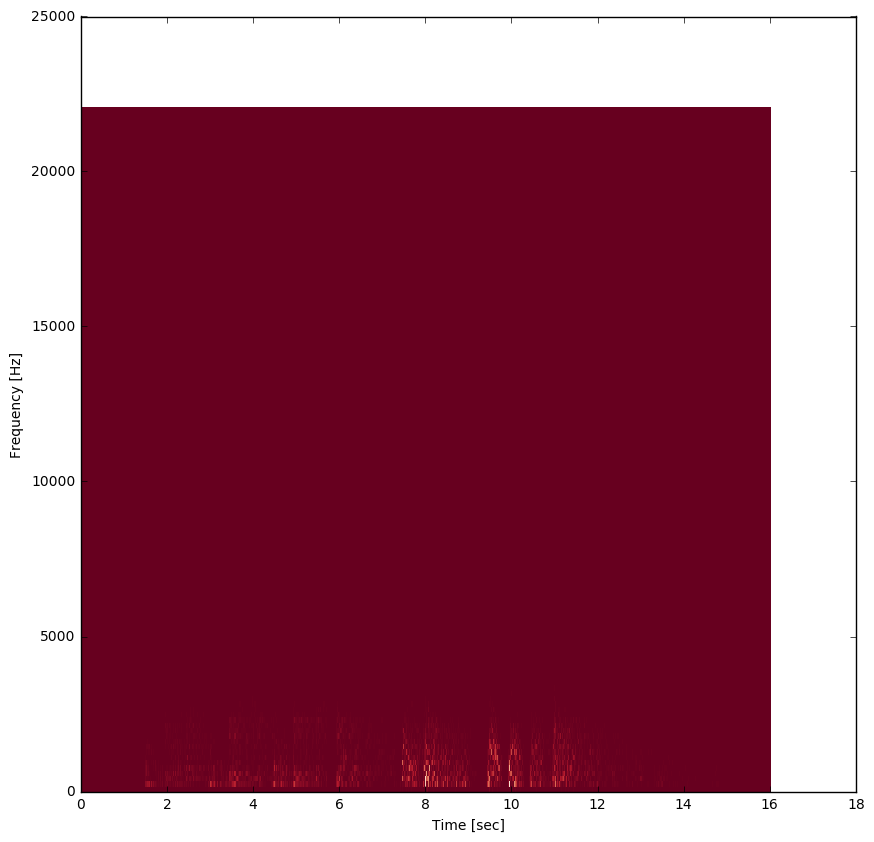

In [26]:
f, t, Sxx = spectrogram(np.absolute(samples), sample_rate)
print(f.shape)
print(t.shape)
print(Sxx.shape)
plt.figure(figsize=(10,10))
plt.pcolormesh(t, f, Sxx, cmap='RdBu')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

(129,)
[     0.          172.265625    344.53125     516.796875    689.0625
    861.328125   1033.59375    1205.859375   1378.125      1550.390625
   1722.65625    1894.921875   2067.1875     2239.453125   2411.71875
   2583.984375   2756.25       2928.515625   3100.78125    3273.046875
   3445.3125     3617.578125   3789.84375    3962.109375   4134.375
   4306.640625   4478.90625    4651.171875   4823.4375     4995.703125
   5167.96875    5340.234375   5512.5        5684.765625   5857.03125
   6029.296875   6201.5625     6373.828125   6546.09375    6718.359375
   6890.625      7062.890625   7235.15625    7407.421875   7579.6875
   7751.953125   7924.21875    8096.484375   8268.75       8441.015625
   8613.28125    8785.546875   8957.8125     9130.078125   9302.34375
   9474.609375   9646.875      9819.140625   9991.40625   10163.671875
  10335.9375    10508.203125  10680.46875   10852.734375  11025.
  11197.265625  11369.53125   11541.796875  11714.0625    11886.328125
  12058.59375  

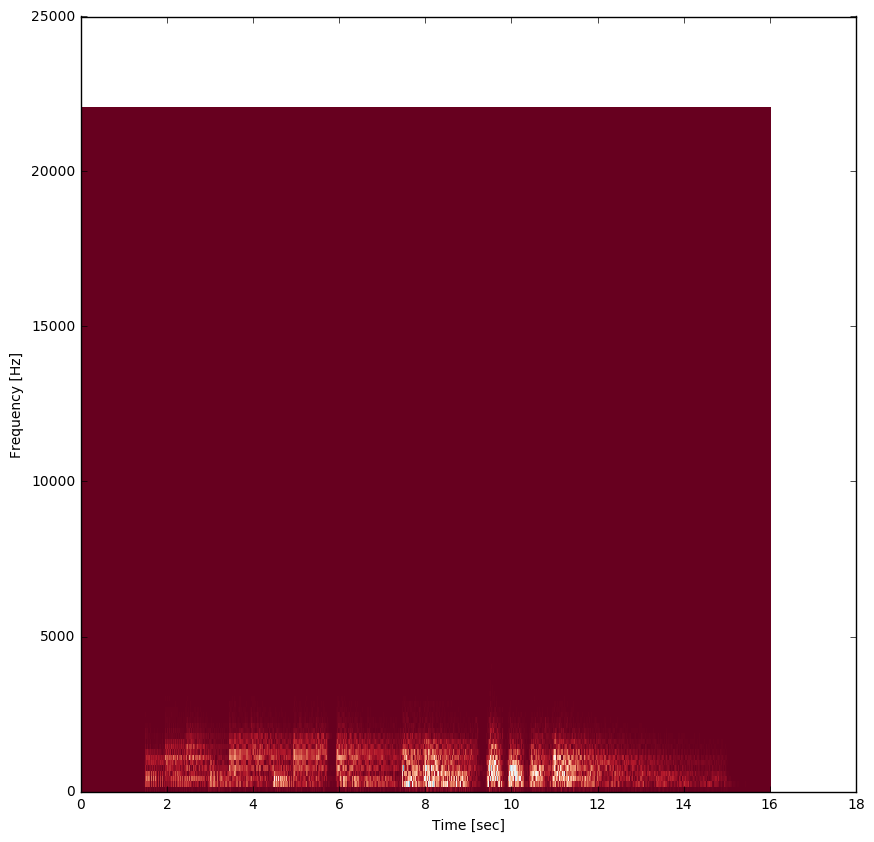

In [29]:
f, t, Sxx = spectrogram(samples, sample_rate, mode='magnitude')
print(f.shape)
print(f)
print(t.shape)
print(t)
print(Sxx.shape)
plt.figure(figsize=(10,10))
plt.pcolormesh(t, f, Sxx, cmap='RdBu')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

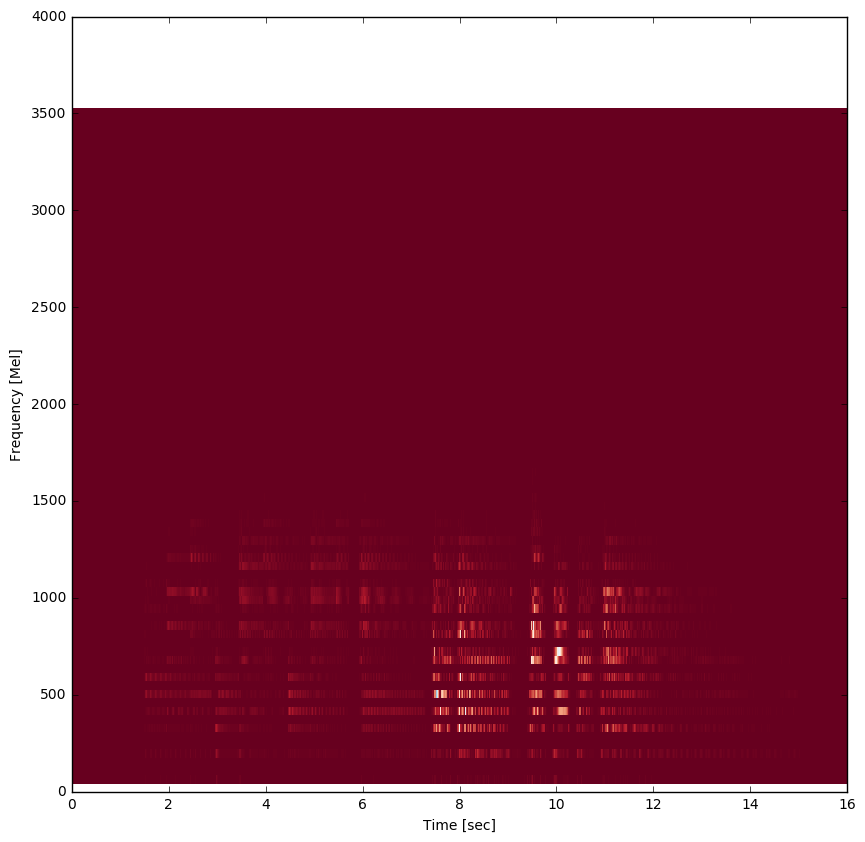

In [57]:
def to_mel(freq):
    return 1125 * math.log(1 + freq/700)

winlen = 0.046
winstep = 0.01
lowfreq = 27.5
highfreq = 16000
features, _ = fbank(samples, sample_rate, winlen=winlen, winstep=winstep, nfilt=80, lowfreq=lowfreq, highfreq=highfreq, preemph=0)
# features = logfbank(samples, sample_rate, winstep=winstep, nfilt=80, lowfreq=lowfreq, highfreq=highfreq, preemph=0)
t_len, f_len = features.shape
mel_lowfreq = to_mel(lowfreq)
mel_highfreq = to_mel(highfreq)
f = np.arange(mel_lowfreq, mel_highfreq, (mel_highfreq - mel_lowfreq)/f_len)
t = np.arange(0.0, t_len*winstep, winstep)

plt.figure(figsize=(10,10))
plt.pcolormesh(t, f, features.T, cmap='RdBu')
plt.ylabel('Frequency [Mel]')
plt.xlabel('Time [sec]')

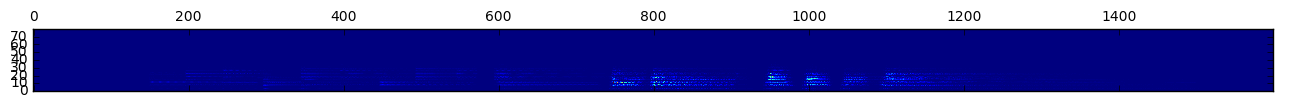

In [58]:
plt.matshow(features.T, origin='lower')

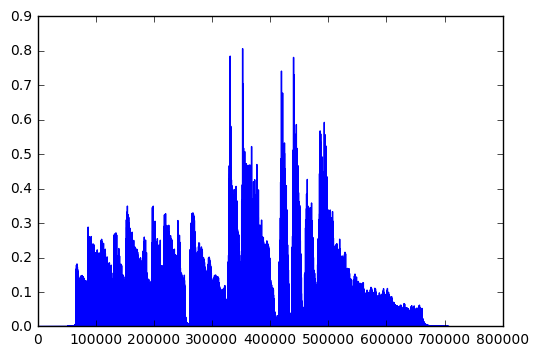

In [19]:
plt.plot(np.absolute(samples))

In [2]:
active_datasets = {1, 2, 3, 4}
X_parts, y_parts, y_start_only_parts, ds_labels = read_data(active_datasets, subsampling_step=1)

D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:149: UserWarning: No truth found for AR_Lick11_FN.wav, skipping file.
  warn('No truth found for ' + wav_file + ', skipping file.')
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:149: UserWarning: No truth found for AR_Lick11_KN.wav, skipping file.
  warn('No truth found for ' + wav_file + ', skipping file.')
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:149: UserWarning: No truth found for AR_Lick11_MN.wav, skipping file.
  warn('No truth found for ' + wav_file + ', skipping file.')
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:151: UserWarning: Skipping non-wav file data\IDMT-SMT-GUITAR_V2\dataset2\audio\desktop.ini
  warn('Skipping non-wav file ' + path_to_wav)
D:\Users\Michel\Documents\FH\module\8_IP6\git\onset_detection\read_data.py:149: UserWarning: No truth found for FS_Lick11_FN.wav, skipping file.
  warn('No truth foun

In [62]:
X_parts_train, X_parts_test, y_parts_train, y_parts_test, y_start_only_parts_train, y_start_only_parts_test, ds_labels_train, ds_labels_test = train_test_split(
    X_parts, y_parts, y_start_only_parts, ds_labels, test_size=0.2, random_state=42
)

In [63]:
X_train = np.concatenate(X_parts_train)
X_test = np.concatenate(X_parts_test)
y_train = np.concatenate(y_parts_train).ravel()
y_test = np.concatenate(y_parts_test).ravel()

y_start_only_train = np.concatenate(y_start_only_parts_train)
y_start_only_test = np.concatenate(y_start_only_parts_test)

ds_labels_flat_train = []
for y_part, ds_label in zip(y_parts_train, ds_labels_train):
    ds_labels_part = np.empty(len(y_part), dtype=np.int8)
    ds_labels_part.fill(ds_label)
    ds_labels_flat_train.append(ds_labels_part)
ds_labels_flat_train = np.concatenate(ds_labels_flat_train).ravel()

ds_labels_flat_test = []
for y_part, ds_label in zip(y_parts_test, ds_labels_test):
    ds_labels_part = np.empty(len(y_part), dtype=np.int8)
    ds_labels_part.fill(ds_label)
    ds_labels_flat_test.append(ds_labels_part)
ds_labels_flat_test = np.concatenate(ds_labels_flat_test).ravel()

print(X_train.shape)
print(y_train.shape)
print(y_start_only_train.shape)
print(ds_labels_flat_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_start_only_test.shape)
print(ds_labels_flat_test.shape)

(940179, 111)
(940179,)
(940179,)
(940179,)
(231747, 111)
(231747,)
(231747,)
(231747,)
